# Class 10 - The k-nearest neighbour algorithm

The $k$-nearest neighbour algorithm is probably one of the most simple classification algorithm existing. The general idea is to predict the label of a new datapoint according to the label(s) of the closest training point(s) to it.

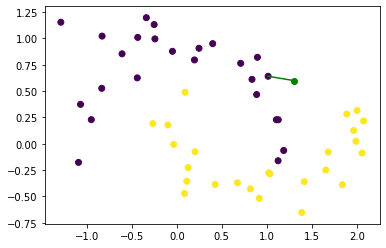

In [1]:
%matplotlib inline
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import math

x, y = make_moons(50, noise=0.2, random_state=5)#random_state=5

plt.scatter(x[:,0], x[:,1], c=y)
plt.scatter([1.3], [0.6],c="g")
plt.plot((1.0141,1.3),(0.6409,0.6),"g")
plt.show()

Intuitively, it is a good idea to simply decide the label of a newly observed datapoint according to the label of the closest given point in the training set. Unfortunately, this leads to the following two problems:
- The algorithm is not generalizing well as points at the boundary get a huge say whereas points in the bulk only get a small voice.
- Outliers contribute to the prediction as much as the "well-located" points. This also prevents the algorithm from generalizing well.

To solve these issues one usually considers the $k$-nearest neighbours of a new point instead of only the closest given one. These points then are used to perform a majority vote with the hope that outliers do not contribute too much anymore.

To implement the $k$-nearest neighbour algorithm, we simply need to store all training data in memory and while predicting search for the closest $k$ points within this set.

The $k$-nearest neighbour algorithm works non-parametric which means that there is no parametrized underlying hypothesis class from which we are trying to learn. Therefore it has a huge capability of capturing non-smooth, complex decision boundaries. This is for example useful in recognizing hand-written digits sucessfully.

Advantages:
- Applies easily to multiclass classification
- Building the model is very fast

Disadvantages:
- Prediction is very slow especially for large number of features.
- Need to preprocess/standardize data
- Bad in treating sparse data
- Suffers from curse of dimensionality, i.e. needed sample size grows exponentially in number of features

## The role of $k$

More neighbours means smoother boundary and smoother decision boundary corresponds to simpler model. On the other hand, the boundary for small values of $k$ gets very rough. Hence, the decision rule gets more complicated. Put differently, low k corresponds to high model complexity and high k corresponds to low model complexity.

In practice, one often starts to train the algorithm with $k=3$ or $k=5$ and adapts accordingly afterwards.

In some problems it might also be helpful to let the value of $k$ to depend on the averaged local density of points in the training data. One approach to obtain this is to apply a radius-based approach (cf. RadiusNeighborsClassifyer in sklearn). The idea for this is to consider all training points within a fixed radius $r$ around the new datapoint instead of only the $k$ closest ones. The advantage compared to a classical $k$-nearest neighbour algorithm is that the influence of a given point in the training set is limited to a fixed region.

## How to compute nearest neighbours?

Finding the nearest neighbour in a fast way is usually a quite challenging problem. On the other hand, it can also be done quite fast depending on the problem - for example Google uses a nearest neighbour search in its algorithm and manages to search through 30 trillion web pages.

Developing fast and storage-economical nearest neighbour search algorithms is still an active part of research. Usually, such algorithms have to perform a delicate tradeoff between the low time for query and the space complexity needed. In general, the better the data are sorted and stored, the faster one can search them but storing these complex data structures demands a lot of storage space. One option to avoid this problem (at least slightly) is by considering so-called $r$-approximate searchs only. Some of the most important nearest neighbour algorithms are:

*Brute force*: Compute all distances and search for the smallest among all of them. The time for a query scales like $O(dn^2)$ while the needed storage scales like $O(dn)$. Make sure that calculation of your distance can be done fast.

*k-d-tree*: Apply the principle “If A distant to B and C close to B than C distant from A without computing it”. Computational time scales like $O(dnlogn)$. The idea to build such a tree is to partition the data set into close and distant points. Efficent until roughly d=20.

*ball-tree*: Construct tree structure not along cartesian axis but use proper balls together with the triangle inequality to get estimate for distrances. This algorithm provides much faster prediction rates but needs very long to build the data structure.

## The algorithm

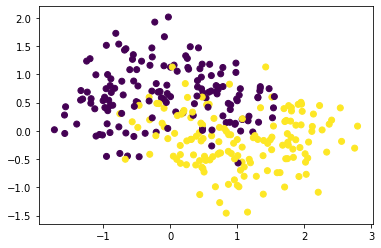

In [2]:
%matplotlib inline
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import math

x, y = make_moons(300, noise=0.4, random_state=5)

plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

For prediction we decided to implement the brute force method. This method works best for a small number of samples and low feature dimensions.

In [3]:
def eucl_dist(x, y, axis=None):
    return np.linalg.norm(x-y, axis=axis)

def kNN_train(x, y, nr_neighbours=1, dist=eucl_dist):
    # Standardize data and add column of ones
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    return [(x-x_mean)/x_std, x_mean, x_std, y, nr_neighbours, dist]

def max_vote(y): # Y of the shape: nr_samples × nr_neighbours
    u, indices = np.unique(y, return_inverse=True)
    return u[np.argmax(np.apply_along_axis(np.bincount, 1, indices.reshape(y.shape), None, np.max(indices) + 1), axis=1)]

def kNN_predict(x_pred, kNN):
    x, x_mean, x_std, y, nr_neighbours, dist = kNN
    
    # Standardize data accordingly
    x_pred = (x_pred-x_mean)/x_std
    
    # Instead of looping through all elements in x_pred we perform all calculations in parallel using numpys broadcasting
    # Shape: nr_samples_to_predict × nr_samples × nr_features
    x=x.reshape(1,*x.shape)
    x_pred = x_pred.reshape(x_pred.shape[0],1,x_pred.shape[1])
    
    # Average over features
    dist_x_xpred = dist(x, x_pred, axis=2)
    
    # Find the smallest nr_neighboughs one
    k_nearest_position = np.argpartition(dist_x_xpred, nr_neighbours-1)
    
    # Select k nearest outputs for any sample_to_predict
    # new shape: nr_samples_to_predict × nr_neighbours
    k_nearest_outputs = np.take_along_axis(y.reshape(1,-1), k_nearest_position, axis=1)[:,:nr_neighbours]
    
    # Perform prediction by maximum vote.
    return max_vote(k_nearest_outputs)

We also need our standard preprocessing functions.

In [4]:
def shuffle(x, y):
    y = y.reshape(-1,1)
    z = np.hstack((x, y))
    np.random.shuffle(z)
    x_new, y_new = np.hsplit(z, [x.shape[1]])
    return x_new, y_new.reshape(-1)

def splitting(x, y, test_size=0.2):
    n = x.shape[0]
    train_size = int(n * (1 - test_size))
    return x[:train_size, ], x[train_size:, ], y[:train_size, ], y[train_size:, ]

def validation_split(x, y, validation_size=0.15, test_size=0.15):
    n = x.shape[0]
    train_cut = int(np.floor(n * (1 - validation_size - test_size)))
    val_cut = train_cut + int(np.floor(n * validation_size))
    return x[:train_cut, ], x[train_cut:val_cut, ], x[val_cut:, ], y[:train_cut, ], y[train_cut:val_cut, ], y[val_cut:,]

In [5]:
def zero_one_loss(y_true, y_pred):
    n = y_true.shape[0]
    return (1/n) * np.sum(y_true != y_pred)

Now, we are able to apply our algorithm.

In [6]:
x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = splitting(x, y)


kNN = kNN_train(x_train, y_train, nr_neighbours=1)

train_predicted = kNN_predict(x_train, kNN)
test_predicted = kNN_predict(x_test, kNN)

print('Train 0-1 loss:', zero_one_loss(y_train, train_predicted))
print('Test 0-1 loss:', zero_one_loss(y_test, test_predicted))

Train 0-1 loss: 0.0
Test 0-1 loss: 0.3


As already seen in the non-linear SVM algorithm, it is not possible to determine the prediction rule in a simple way. Thus, we draw the decision boundary to get an understanding of how our algorithm predicts.

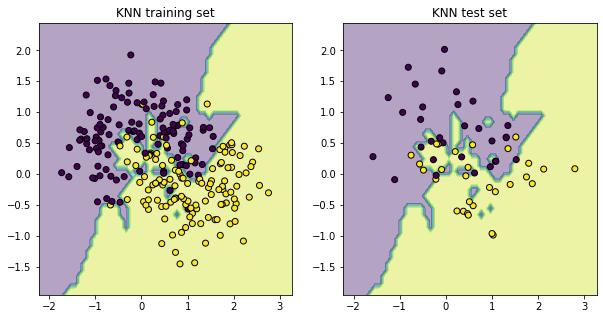

In [7]:
# Draws the decision boundary for a classifyer with two features
def decision_boundary(clf, plt, x1_range, x2_range):
    # Create grid
    xx1, xx2 = np.meshgrid(np.arange(x1_range[0], x1_range[1], 0.1),
                     np.arange(x2_range[0], x2_range[1], 0.1))
    
    # Predict on all values
    y = kNN_predict(np.c_[xx1.reshape(-1), xx2.reshape(-1)], kNN)
    y = y.reshape(xx1.shape)
    
    # Plot contour
    plt.contourf(xx1, xx2, y, alpha=0.4)

# Plot both training and testing
f, subplt = plt.subplots(1, 2, figsize=(10, 5))
x1_range = [x[:, 0].min() - 1/2, x[:, 0].max() + 1/2]
x2_range = [x[:, 1].min() - 1/2, x[:, 1].max() + 1/2]

subplt[0].set_title("KNN training set")
decision_boundary(kNN, subplt[0], x1_range, x2_range)
subplt[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor='k')

subplt[1].set_title("KNN test set")
decision_boundary(kNN, subplt[1], x1_range, x2_range)
subplt[1].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolor='k')


plt.show()

Notice that the decision boundary is very rough so that it probably generalizes poorly. Let's compare the boundary for different levels of $k$.

### Comparing different levels of k

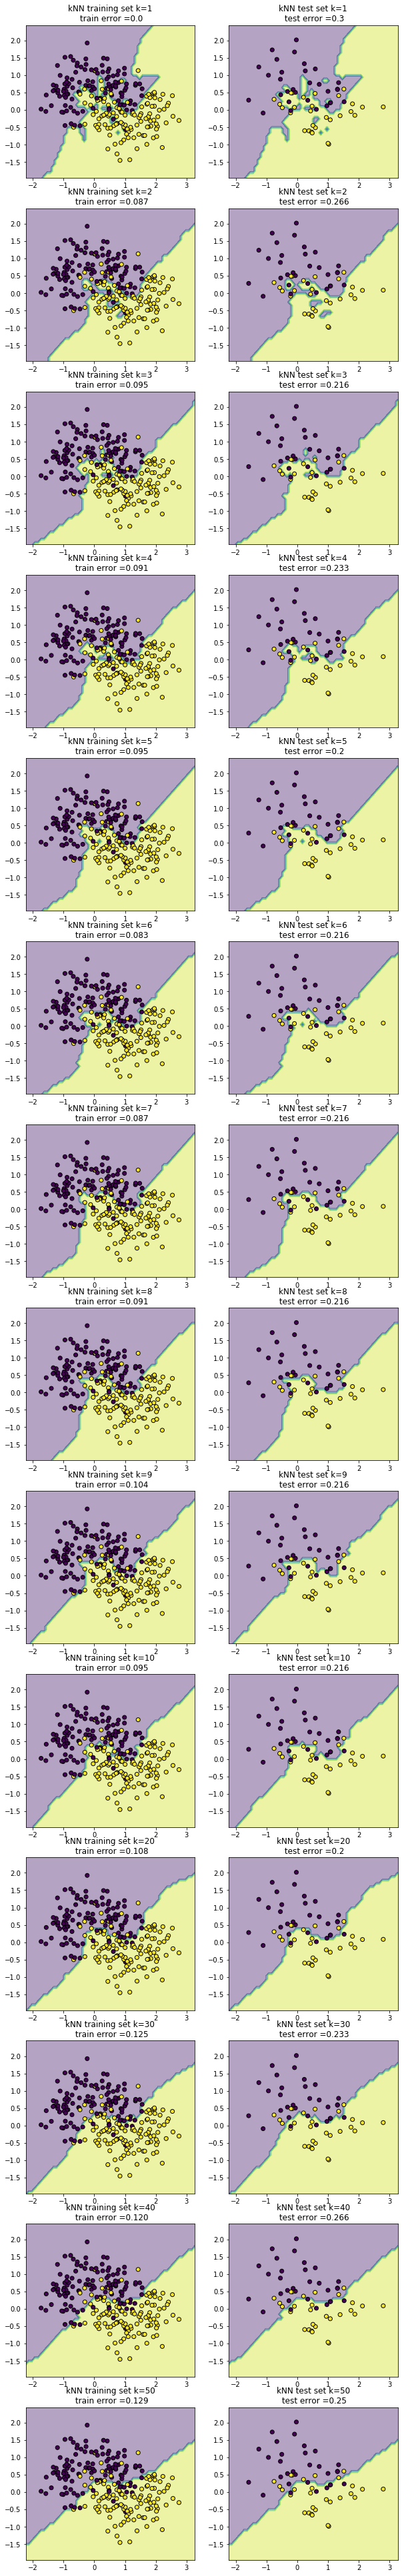

In [8]:
k_list=[1,2,3,4,5,6,7,8,9,10,20,30,40,50]

# Plot both training and testing
f, subplt = plt.subplots(len(k_list), 2, figsize=(10, 5*len(k_list)))
x1_range = [x[:, 0].min() - 0.5, x[:, 0].max() + 0.5]
x2_range = [x[:, 1].min() - 0.5, x[:, 1].max() + 0.5]

for i in range(len(k_list)):
    kNN = kNN_train(x_train, y_train, nr_neighbours=k_list[i])

    train_predicted = kNN_predict(x_train, kNN)
    test_predicted = kNN_predict(x_test, kNN)

    subplt[i,0].set_title("kNN training set k="+str(k_list[i])
                          +"\n train error ="+str(zero_one_loss(y_train, train_predicted))[:5])
    decision_boundary(kNN, subplt[i,0], x1_range, x2_range)
    subplt[i,0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor='k')
    

    subplt[i,1].set_title("kNN test set k="+str(k_list[i])
                          +"\n test error ="+str(zero_one_loss(y_test, test_predicted))[:5])
    decision_boundary(kNN, subplt[i,1], x1_range, x2_range)
    subplt[i,1].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolor='k')



## Application to a “real” problem

Finally, let us investigate how the $k$-nearest neighbour algorithm performs on a real dataset. We consider here the [wine dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) from sklearn.

In [9]:
from sklearn.datasets import load_wine

wine = load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [10]:
x = wine.data
y = wine.target

print(x.shape)
print(y.shape)

(178, 13)
(178,)


As the dataset is quite small we decided to perform a standard validation and compare it to the leave one out cross validation.

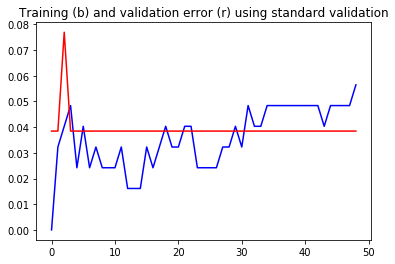

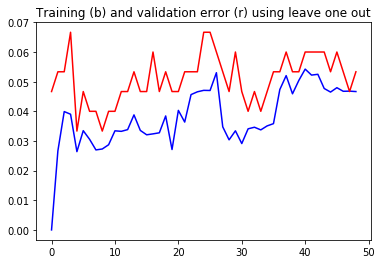

In [11]:
from sklearn.model_selection import LeaveOneOut

#np.random.seed(5)
x, y = shuffle(x, y)

x_train, x_validation, x_test, y_train, y_validation, y_test = validation_split(x, y)
# Doing a normal validation might be not so efficient as the dataset is quite small.
# So we also perform cross-validation (leave one out).
x_train_cv = np.vstack((x_train,x_validation))
y_train_cv = np.hstack((y_train,y_validation))

train_errors = []
validation_errors = []
train_errors_cv = []
validation_errors_cv = []

for i in range(1,50):
    # Standard validation
    kNN = kNN_train(x_train, y_train, nr_neighbours=i)
    train_predicted = kNN_predict(x_train, kNN)
    validation_predicted = kNN_predict(x_validation, kNN)
    train_errors.append(zero_one_loss(y_train, train_predicted))
    validation_errors.append(zero_one_loss(y_validation, validation_predicted))
    
    #Leave one out cross validation
    loo = LeaveOneOut()
    train_errors_loo = []
    validation_errors_loo = []
    for train_index, test_index in loo.split(x_train_cv):
        x_train_loo = x_train_cv[train_index,:]
        y_train_loo = y_train_cv[train_index]
        x_validation_loo = x_train_cv[test_index,:]
        y_validation_loo = y_train_cv[test_index]
        
        kNN_loo = kNN_train(x_train_loo, y_train_loo, nr_neighbours=i)
        train_predicted_loo = kNN_predict(x_train_loo, kNN_loo)
        validation_predicted_loo = kNN_predict(x_validation_loo, kNN_loo)
        train_errors_loo.append(zero_one_loss(y_train_loo, train_predicted_loo))
        validation_errors_loo.append(zero_one_loss(y_validation_loo, validation_predicted_loo))
    train_errors_cv.append(sum(train_errors_loo)/len(train_errors_loo))
    validation_errors_cv.append(sum(validation_errors_loo)/len(validation_errors_loo))

plt.title("Training (b) and validation error (r) using standard validation")
plt.plot(train_errors, "b")
plt.plot(validation_errors, "r")
plt.show()

plt.title("Training (b) and validation error (r) using leave one out")
plt.plot(train_errors_cv, "b")
plt.plot(validation_errors_cv, "r")
plt.show()

Finally, let us see how we can use the $k$-nearest neighbour algorithm as implented in scikit-learn.

In [12]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=i).fit(x_train, y_train)
score = clf.score(x_validation, y_validation)
    
print(score)

0.7692307692307693


In [13]:

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=i)
clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=49, p=2,
                     weights='uniform')

## Exercises

1. Think about how to draw decision boundaries for the wine dataset. Can you see something when looking at the dataset?
2. Compare the performance of the $k$-nearest neighbour algorithm with the other classifiers you have seen, e.g. on the titanic problem.
3. Adapt the idea of the $k$-nearest neighbour algorithm to implement a $k$-nearest neighbour regressor. Apply it to a toy problem as well as to "real" problem like the Boston house price dataset to investigate its performance.
4. Implement weights in our $k$-nearest neighbour algorithm so that closer points contribute more in the prediction than points further away. Compare this new algorithm to the standard $k$-nearest neighbour algorithm without weights.